In [1]:
import json
import os
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import PchipInterpolator, interp1d

Lets first make a plot that shows the mass of Ex-situ formed GCs

In [2]:
def get_type_flag(gc, grp, gc_survive_lst):
    if gc in gc_survive_lst:
        if grp == 0:
            # formed in-situ and survived to z = 0
            type_flag = 0
        elif grp > 0:
            # formed ex-situ, accreted and survived to z = 0
            type_flag = 2

    elif grp < -2:
        # formed ex-situ and died before accretion
        type_flag = 4

    elif grp > 0:
        # formed ex-situ, accreted but died before z = 0
        type_flag = 3

    elif grp == 0:
        # formed in-situ, but died before z = 0
        type_flag = 1

    else:
        sys.exit("Some GC Missing Type Flag")

    return type_flag

In [3]:
def get_mass_data(it, evolve_mass_loss, sim, sim_dir, save_dir, save_dict=True, return_dict=False):
    # get required files

    proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
    proc_data = h5py.File(proc_file, "r")  # open processed data file

    pub_data = sim_dir + "snapshot_times_public.txt"
    pub_snaps = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
    pub_snaps.columns = [
        "index",
        "scale_factor",
        "redshift",
        "time_Gyr",
        "lookback_time_Gyr",
        "time_width_Myr",
    ]

    mass_dict = {}

    it_id = iteration_name(it)
    mass_dict[it_id] = {}

    src_dat = proc_data[it_id]["source"]
    ana_mask = np.array(src_dat["analyse_flag"]) == 1

    gc_lst = np.array(src_dat["gc_id"])[ana_mask]
    gc_survive_lst = np.array(proc_data[it_id]["snapshots"]["snap600"]["gc_id"])

    for gc in gc_lst:
        gc_id = str(gc)
        mass_dict[it_id][gc_id] = {}

        idx = np.where(np.array(src_dat["gc_id"])[ana_mask] == gc)[0][0]
        grp = np.array(src_dat["group_id"])[ana_mask][idx]

        mass_dict[it_id][gc_id]["group_id"] = int(grp)
        mass_dict[it_id][gc_id]["type_flag"] = get_type_flag(gc, grp, gc_survive_lst)

        time_lst = []
        time_for_lst = []

        log_mass_lst = []  # mass at each time
        mass_loss_lst = []  # mass loss
        mass_loss_det_lst = []  # mass loss but taking t_form as 55% of t_form

        # get formation information
        t_form = np.array(src_dat["form_time"])[ana_mask][idx]

        log_mass_form = np.array(src_dat["logm_tform"])[ana_mask][idx]
        log_mass_form_det = (
            np.log10(1 - evolve_mass_loss) + log_mass_form
        )  # corrected for mass loss by evolution

        # get other details
        t_dis = np.array(src_dat["t_dis"])[ana_mask][idx]

        # update relevant lists
        time_lst.append(t_form)
        time_for_lst.append(t_form - t_form)

        # only for accreted (types 2, 3, 4) GCs
        if mass_dict[it_id][gc_id]["type_flag"] > 1:
            time_acc_lst = []

            t_acc = np.array(src_dat["t_acc"])[ana_mask][idx]
            time_acc_lst.append(t_form - t_acc)

        log_mass_lst.append(log_mass_form)

        # add mass loss as 0 for first time step
        mass_loss_lst.append(0)
        mass_loss_det_lst.append(0)

        if t_dis == -1:
            snap_lst = pub_snaps[(pub_snaps["time_Gyr"] >= t_form)]["index"]
        else:
            snap_lst = pub_snaps[(pub_snaps["time_Gyr"] >= t_form) & (pub_snaps["time_Gyr"] <= t_dis)][
                "index"
            ]

        # this has been added to ensure that GCs that form and die between snaps are considered in the for loop
        # that gets the details of their death (death loop)
        time = t_form

        for snap in snap_lst:
            snap_id = snapshot_name(snap)
            snap_dat = proc_data[it_id]["snapshots"][snap_id]

            # check, sometimes timing issues with GC formation model
            gc_snap_lst = np.array(snap_dat["gc_id"])
            if gc not in gc_snap_lst:
                continue

            time = pub_snaps[pub_snaps["index"] == snap]["time_Gyr"].values[0]

            snap_idx = np.where(np.array(snap_dat["gc_id"]) == gc)[0][0]
            cur_log_mass = np.array(snap_dat["mass"])[snap_idx]

            pst_log_mass = log_mass_lst[-1]
            pst_mass = 10**pst_log_mass

            cur_mass = 10**cur_log_mass

            # get mass loss (not logged)
            mass_los = pst_mass - cur_mass

            # make initial correction to detectable mass loss list
            if len(log_mass_lst) == 1:
                mass_form_det = 10**log_mass_form_det
                mass_los_det = mass_form_det - cur_mass
            else:
                mass_los_det = mass_los

            # update relevant lists
            log_mass_lst.append(cur_log_mass)

            mass_loss_lst.append(mass_los)
            mass_loss_det_lst.append(mass_los_det)

            time_lst.append(time)
            time_for_lst.append(time - t_form)

            # get accretion time
            if mass_dict[it_id][gc_id]["type_flag"] > 1:
                time_acc_lst.append(time - t_acc)

        # need to consider full disruption stuff too
        # like if in past list but not in current list mass loss is 100%

        # (death loop)
        # update full disruption details fro GCs that don't survive to z = 0

        # if (mass_dict[it_id][gc]["type_flag"] != 0) and (mass_dict[it_id][gc]["type_flag"] != 2):
        #     last_time = pub_snaps[pub_snaps["time_Gyr"] > time]["time_Gyr"].values[0]

        if t_dis != -1:
            # no longer exists
            # final_log_mass = np.nan
            final_log_mass = None

            # past mass
            pst_log_mass = log_mass_lst[-1]
            pst_mass = 10**pst_log_mass

            # as fully disrupted
            mass_los = pst_mass

            time_lst.append(t_dis)
            time_for_lst.append(t_dis - t_form)

            # get accretion time
            if mass_dict[it_id][gc_id]["type_flag"] > 1:
                time_acc_lst.append(t_dis - t_acc)

            log_mass_lst.append(final_log_mass)
            mass_loss_lst.append(mass_los)
            mass_loss_det_lst.append(mass_los)

        # update dictionary
        mass_dict[it_id][gc_id]["time"] = time_lst
        mass_dict[it_id][gc_id]["form_time"] = time_for_lst

        if mass_dict[it_id][gc_id]["type_flag"] > 1:
            mass_dict[it_id][gc_id]["acc_time"] = time_acc_lst

        mass_dict[it_id][gc_id]["log_mass"] = log_mass_lst
        mass_dict[it_id][gc_id]["mass_loss"] = mass_loss_lst
        mass_dict[it_id][gc_id]["mass_loss_detectable"] = mass_loss_det_lst

    # close file
    proc_data.close()

    if save_dict:
        save_file = save_dir + "/" + it_id + "_gc_mass_data.json"

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        with open(save_file, "w") as f:
            json.dump(mass_dict, f, indent=4)  # `indent=4` makes it more readable

    if return_dict:
        return mass_dict

In [4]:
# Save to a JSON file
evolve_mass_loss = 0.45

it_min = 0
it_max = 0
# it_max = 100

sim = "m12i"

sim_dir = "/Users/z5114326/Documents/simulations/"
save_dir = "../data/gc_mass_data/" + sim

In [5]:
for it in range(it_min, it_max + 1):
    get_mass_data(it, evolve_mass_loss, sim, sim_dir, save_dir, save_dict=True, return_dict=False)

# Lets plot

First lets get common time grids across all iterations

In [98]:
def time_bounds(it_min, it_max, save_dir):
    # the min for both these time frames will be 0
    time_max = 0
    form_time_max = 0

    acc_time_min = 0
    acc_time_max = 0

    for it in range(it_min, it_max + 1):
        it_id = iteration_name(it)

        data_file = save_dir + "/" + it_id + "_gc_mass_data.json"

        # open json file as dict
        with open(data_file, "r") as file:
            mass_dict = json.load(file)

        for gc_id in mass_dict[it_id].keys():
            it_time_max = np.max(mass_dict[it_id][gc_id]["time"])
            time_max = np.max([time_max, it_time_max])

            it_form_time_max = np.max(mass_dict[it_id][gc_id]["form_time"])
            form_time_max = np.max([form_time_max, it_form_time_max])

            if mass_dict[it_id][gc_id]["type_flag"] > 1:
                it_acc_time_min = np.min(mass_dict[it_id][gc_id]["acc_time"])
                it_acc_time_max = np.max(mass_dict[it_id][gc_id]["acc_time"])

                acc_time_min = np.min([acc_time_min, it_acc_time_min])
                acc_time_max = np.max([acc_time_max, it_acc_time_max])

    time_bounds_dict = {
        "time": [0, time_max],
        "form_time": [0, form_time_max],
        "acc_time": [acc_time_min, acc_time_max],
    }

    return time_bounds_dict

In [99]:
it_min = 0
it_max = 100

time_bounds_dict = time_bounds(it_min, it_max, save_dir)

In [100]:
time_bounds_dict

{'time': [0, 13.835],
 'form_time': [0, 13.420585091],
 'acc_time': [-12.874355446, 12.286746883]}

In [103]:
time_step = 1000
time_grid = np.linspace(time_bounds_dict["time"][0], time_bounds_dict["time"][1], time_step)
form_time_grid = np.linspace(time_bounds_dict["form_time"][0], time_bounds_dict["form_time"][1], time_step)
acc_time_grid = np.linspace(time_bounds_dict["acc_time"][0], time_bounds_dict["acc_time"][1], time_step)

In [105]:
def safe_interpolate(x, y, common_grid):
    interp_func = interp1d(x, y, kind="nearest", bounds_error=False, fill_value=(0, 1))
    return interp_func(common_grid)

In [ ]:
it_min = 0
it_max = 0

####################################
plot_dict = {}

plot_dict["time"] = time_grid
plot_dict["form_time"] = form_time_grid
plot_dict["acc_time"] = acc_time_grid

####################################

for it in range(it_min, it_max + 1):
    it_id = iteration_name(it)

    data_file = save_dir + "/" + it_id + "_gc_mass_data.json"
    # open json file as dict
    with open(data_file, "r") as file:
        mass_dict = json.load(file)

    plot_dict[it_id] = {}

    plot_dict[it_id]["0"] = {}
    plot_dict[it_id]["1"] = {}
    plot_dict[it_id]["2"] = {}
    plot_dict[it_id]["3"] = {}
    plot_dict[it_id]["4"] = {}

    # set up dictionary
    for type_flag_val in range(0, 5):
        plot_dict[it_id][str(type_flag_val)] = {}

        #######################################################################################
        # need to make a mass list for each time frame
        # cosmic time
        time_len = len(plot_dict["time"])
        plot_dict[it_id][str(type_flag_val)]["time"] = {}
        plot_dict[it_id][str(type_flag_val)]["time"]["mass"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["time"]["mass_loss"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["time"]["mass_loss_det"] = np.zeros(time_len)

        # formation time
        time_len = len(plot_dict["form_time"])
        plot_dict[it_id][str(type_flag_val)]["form_time"] = {}
        plot_dict[it_id][str(type_flag_val)]["form_time"]["mass"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["form_time"]["mass_loss"] = np.zeros(time_len)
        plot_dict[it_id][str(type_flag_val)]["form_time"]["mass_loss_det"] = np.zeros(time_len)

        # accretion time
        if type_flag_val > 1:
            time_len = len(plot_dict["acc_time"])
            plot_dict[it_id][str(type_flag_val)]["acc_time"] = {}
            plot_dict[it_id][str(type_flag_val)]["acc_time"]["mass"] = np.zeros(time_len)
            plot_dict[it_id][str(type_flag_val)]["acc_time"]["mass_loss"] = np.zeros(time_len)
            plot_dict[it_id][str(type_flag_val)]["acc_time"]["mass_loss_det"] = np.zeros(time_len)

        #######################################################################################
    for gc_id in mass_dict[it_id]:
        type_flag = mass_dict[it_id][gc_id]["type_flag"]

        time_lst = mass_dict[it_id][gc_id]["time"]
        form_time_lst = mass_dict[it_id][gc_id]["form_time"]

        log_mass_lst = mass_dict[it_id][gc_id]["log_mass"]

        mass_loss_lst = mass_dict[it_id][gc_id]["mass_loss"]
        mass_loss_det_lst = mass_dict[it_id][gc_id]["mass_loss_detectable"]

        mass_lst = []
        for log_mass in log_mass_lst:
            if log_mass is not None:
                mass = 10**log_mass
            else:
                mass = 0
            mass_lst.append(mass)

        ########################################################################################3
        # cosmic time
        time_mass = safe_interpolate(time_lst, mass_lst, plot_dict["time"])
        time_mass_loss = safe_interpolate(time_lst, mass_loss_lst, plot_dict["time"])
        time_mass_loss_det = safe_interpolate(time_lst, mass_loss_det_lst, plot_dict["time"])

        plot_dict[it_id][str(type_flag)]["time"]["mass"] += time_mass
        plot_dict[it_id][str(type_flag)]["time"]["mass_loss"] += time_mass_loss
        plot_dict[it_id][str(type_flag)]["time"]["mass_loss_det"] += time_mass_loss_det

        # formation time
        form_time_mass = safe_interpolate(form_time_lst, mass_lst, plot_dict["form_time"])
        form_time_mass_loss = safe_interpolate(form_time_lst, mass_loss_lst, plot_dict["form_time"])
        form_time_mass_loss_det = safe_interpolate(form_time_lst, mass_loss_det_lst, plot_dict["form_time"])

        plot_dict[it_id][str(type_flag)]["form_time"]["mass"] += form_time_mass
        plot_dict[it_id][str(type_flag)]["form_time"]["mass_loss"] += form_time_mass_loss
        plot_dict[it_id][str(type_flag)]["form_time"]["mass_loss_det"] += form_time_mass_loss_det

        # accretion time
        if type_flag > 1:
            acc_time_lst = mass_dict[it_id][gc_id]["acc_time"]

            acc_time_mass = safe_interpolate(acc_time_lst, mass_lst, plot_dict["acc_time"])
            acc_time_mass_loss = safe_interpolate(acc_time_lst, mass_loss_lst, plot_dict["acc_time"])
            acc_time_mass_loss_det = safe_interpolate(acc_time_lst, mass_loss_det_lst, plot_dict["acc_time"])

            plot_dict[it_id][str(type_flag)]["acc_time"]["mass"] += acc_time_mass
            plot_dict[it_id][str(type_flag)]["acc_time"]["mass_loss"] += acc_time_mass_loss
            plot_dict[it_id][str(type_flag)]["acc_time"]["mass_loss_det"] += acc_time_mass_loss_det

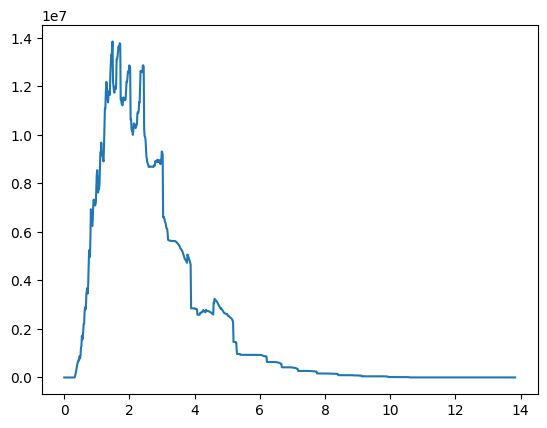

In [ ]:
plt.plot(plot_dict["time"], plot_dict[it_id][str(4)]["time"]["mass"])